In [1]:
import os
from PIL import Image, ImageDraw, ImageFont
import tqdm

In [2]:
dir_path = r'C:\Users\Simone\Desktop\BG15Foto\test_FranzOffice\342-1'
image_list = [f for f in os.listdir(dir_path) if f.endswith(('.jpg', '.png', '.jpeg', 'JPG', 'PNG', 'JPEG'))]
label_list = ()
num_zeroDection = 0
for image in image_list:
    label_dir_poss = (os.path.splitext(image)[0] + '.txt')
    label_dir = os.path.join(dir_path, label_dir_poss)
    if not os.path.exists(label_dir):
        print('label file not exist: ', image)
        num_zeroDection += 1
        continue
    label_list += (label_dir,)
print('num_zeroDection: ', num_zeroDection)
print('label_list has ', len(label_list), ' elements')
print('image_list has ', len(image_list), ' elements')


label file not exist:  16697.jpg
num_zeroDection:  1
label_list has  71  elements
image_list has  72  elements


In [3]:
def readText(path):
    AnnotationDict = {}
    with open(path, 'r') as f:
        lines = f.read()
    for i,line in enumerate(lines.split('\n')):
        if line:
            line = line.split(' ')
            if len(line) == 5:                          #for rectangle, category:str, x:float, y, w, h of the annotation
                category = int(line[0])
                x = float(line[1])
                y = float(line[2])
                w = float(line[3])
                h = float(line[4])
                AnnotationDict[i] = [category, x, y, w, h]
            elif len(line) == 6:                         #for oriented box and ellipse, category:str, x:float, y, w, h, theta:int of the annotation
                category = int(line[0])
                x = float(line[1])
                y = float(line[2])
                w = float(line[3])
                h = float(line[4])
                theta = int(line[5])
                AnnotationDict[i] = [category, x, y, w, h, theta]
            elif len(line) >= 9 and len(line) % 2 == 1:                 #for multi-side polygon, category:str, x1:float, y1, x2, y2, x3, y3, ... of the annotation
                category = int(line[0])
                AnnotationDict[i] = [category]
                AnnotationDict[i].extend([float(x) for x in line[1:]])
    # print(f'processing {path}, got {len(AnnotationDict)} annotations')
    return AnnotationDict


{0: [3, 0.430055, 0.228508, 0.532197, 0.204852, 0.529741, 0.178676, 0.422115, 0.202794], 1: [5, 0.791334, 0.360071, 0.799185, 0.338057, 0.775889, 0.32454, 0.769825, 0.344841], 2: [3, 0.871693, 0.298187, 0.875241, 0.288382, 0.855519, 0.275826, 0.853426, 0.286927], 3: [3, 0.869299, 0.245534, 0.86701, 0.214061, 0.82158, 0.186877, 0.824635, 0.224573], 4: [3, 0.310899, 0.292708, 0.408242, 0.237514, 0.396336, 0.205893, 0.284119, 0.270967], 5: [4, 0.758329, 0.563693, 0.786525, 0.550933, 0.788296, 0.514564, 0.760776, 0.52976]}


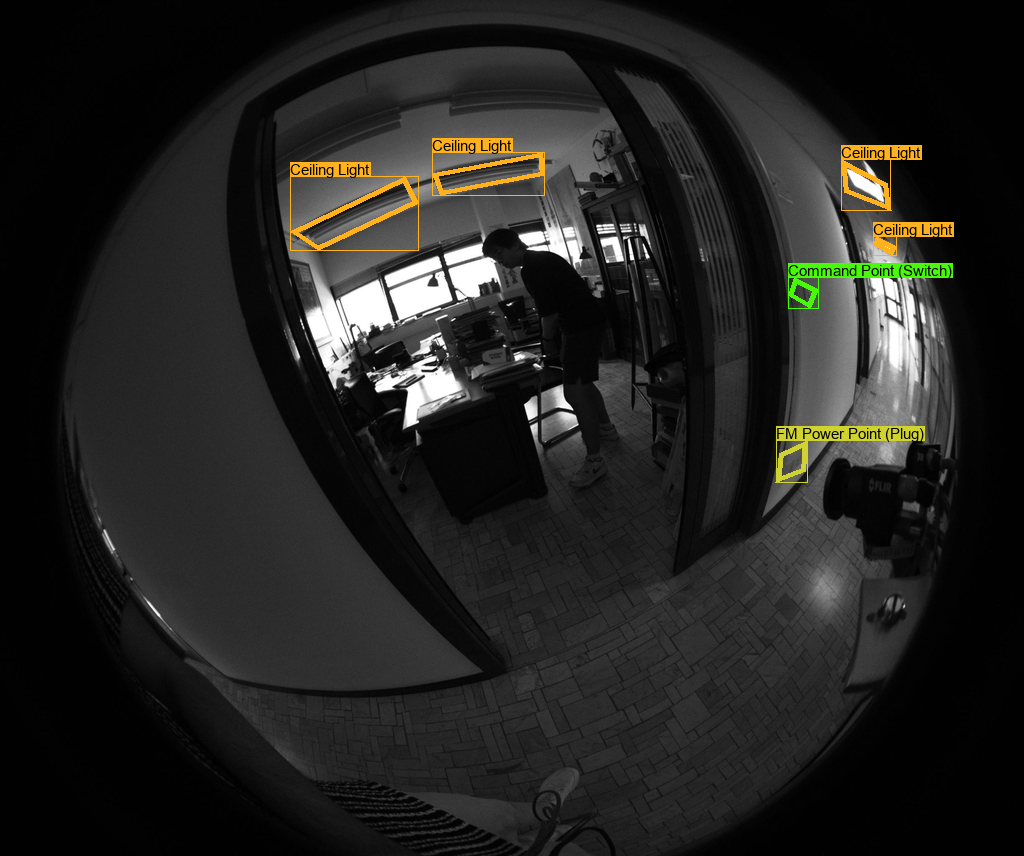

In [ ]:
colorIndex = ('#FF3838', '#FF9D97', '#FF701F', '#FFB21D', '#CFD231', '#48F90A', '#92CC17', '#3DDB86', '#1A9334', '#00D4BB',
              '#2C99A8', '#00C2FF', '#344593', '#6473FF', '#0018EC', '#8438FF', '#520085', '#CB38FF', '#FF95C8', '#FF37C7')
categoryIndex = ('Smoke Detector','Alarm Button','Fire Extinguisher', 'Ceiling Light',
                 'FM Power Point (Plug)', 'Command Point (Switch)','Security Cameras')
def annotateImage(image, annotation, colorIndex=colorIndex, categoryIndex=categoryIndex, resize=True):
    w,h = image.size
    image_anno = image.copy()
    if resize:
        ratio = 1024 / max(w, h)
        w = int(w * ratio)
        h = int(h * ratio)
        image_anno = image_anno.resize((w, h), Image.Resampling.LANCZOS)
        
    draw = ImageDraw.Draw(image_anno)
    for key in annotation:
        category = annotation[key][0]
        color = colorIndex[category % len(colorIndex)]

        if len(annotation[key]) == 5:
            x = annotation[key][1] * w
            y = annotation[key][2] * h
            w_box = annotation[key][3] * w
            h_box = annotation[key][4] * h
            xmin = x - w_box // 2
            ymin = y - h_box // 2
            xmax = x + w_box // 2
            ymax = y + h_box // 2
            draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=5)
            pass
        
        elif len(annotation[key]) == 6:
            pass

        elif len(annotation[key]) >= 9 and len(annotation[key]) % 2 == 1:
            point = []
            box = []
            for i in range(1, len(annotation[key]), 2):
                x = int(annotation[key][i] * w)
                y = int(annotation[key][i+1] * h)
                point.extend([x, y])
            xmin = min(point[::2])
            ymin = min(point[1::2])
            xmax = max(point[::2])
            ymax = max(point[1::2])
            box = [xmin, ymin, xmax, ymax]
            draw.rectangle(box, outline=color, width=1)
            draw.polygon(point, outline=color, width=5)
        # print('category: ', category)
        # print(xmin, ymin, xmax, ymax)
        fontsize = 15
        x_text = xmin
        y_text = ymin-fontsize if ymin > fontsize else ymin
        text = categoryIndex[category]
        
        font = ImageFont.truetype("arial.ttf", fontsize)
        text_bbox = draw.textbbox((x_text, y_text-2), text, font=font)
        text_background = [text_bbox[0], text_bbox[1], text_bbox[2], text_bbox[3]]
        draw.rectangle(text_background, fill=color)
        draw.text((x_text, y_text), text, fill="black", font=font)
    return image_anno

dict_temp = readText(label_list[0])
print(dict_temp)
image = Image.open(os.path.join(dir_path, image_list[0]))
image = image.convert('RGB')
image_anno = annotateImage(image, dict_temp)
image_anno 

{0: [3, 0.430055, 0.228508, 0.532197, 0.204852, 0.529741, 0.178676, 0.422115, 0.202794], 1: [5, 0.791334, 0.360071, 0.799185, 0.338057, 0.775889, 0.32454, 0.769825, 0.344841], 2: [3, 0.871693, 0.298187, 0.875241, 0.288382, 0.855519, 0.275826, 0.853426, 0.286927], 3: [3, 0.869299, 0.245534, 0.86701, 0.214061, 0.82158, 0.186877, 0.824635, 0.224573], 4: [3, 0.310899, 0.292708, 0.408242, 0.237514, 0.396336, 0.205893, 0.284119, 0.270967], 5: [4, 0.758329, 0.563693, 0.786525, 0.550933, 0.788296, 0.514564, 0.760776, 0.52976]}


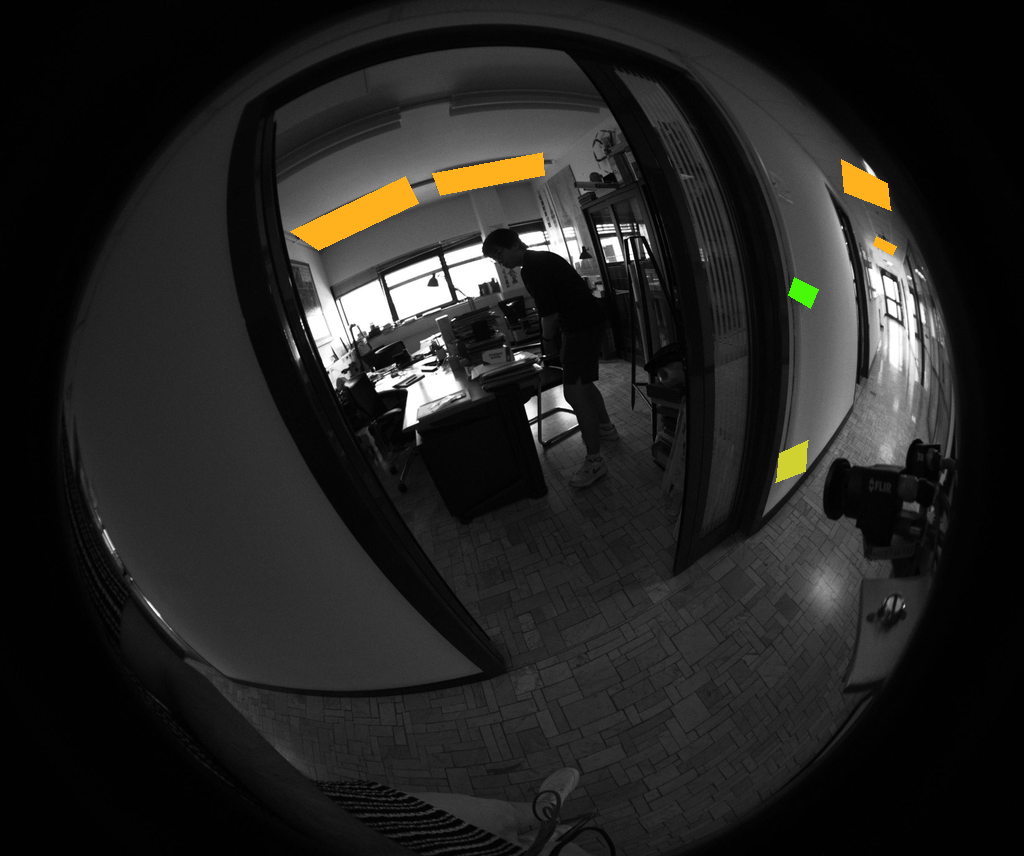

In [7]:
def annotateImage_fullpoly(image, annotation, colorIndex=colorIndex, categoryIndex=categoryIndex, resize=True):
    w,h = image.size
    image_anno = image.copy()
    if resize:
        ratio = 1024 / max(w, h)
        w = int(w * ratio)
        h = int(h * ratio)
        image_anno = image_anno.resize((w, h), Image.Resampling.LANCZOS)
        
    draw = ImageDraw.Draw(image_anno)
    for key in annotation:
        category = annotation[key][0]
        color = colorIndex[category % len(colorIndex)]

        if len(annotation[key]) == 5:
            x = annotation[key][1] * w
            y = annotation[key][2] * h
            w_box = annotation[key][3] * w
            h_box = annotation[key][4] * h
            xmin = x - w_box // 2
            ymin = y - h_box // 2
            xmax = x + w_box // 2
            ymax = y + h_box // 2
            draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=5, fill=color)
            pass
        
        elif len(annotation[key]) == 6:
            pass

        elif len(annotation[key]) >= 9 and len(annotation[key]) % 2 == 1:
            point = []
            box = []
            for i in range(1, len(annotation[key]), 2):
                x = int(annotation[key][i] * w)
                y = int(annotation[key][i+1] * h)
                point.extend([x, y])
            # xmin = min(point[::2])
            # ymin = min(point[1::2])
            # xmax = max(point[::2])
            # ymax = max(point[1::2])
            # box = [xmin, ymin, xmax, ymax]
            # draw.rectangle(box, outline=color, width=1)
            draw.polygon(point, outline=color, width=5, fill=color)
        # print('category: ', category)
        # print(xmin, ymin, xmax, ymax)
        # fontsize = 15
        # x_text = xmin
        # y_text = ymin-fontsize if ymin > fontsize else ymin
        # text = categoryIndex[category]
        
        # font = ImageFont.truetype("arial.ttf", fontsize)
        # text_bbox = draw.textbbox((x_text, y_text-2), text, font=font)
        # text_background = [text_bbox[0], text_bbox[1], text_bbox[2], text_bbox[3]]
        # draw.rectangle(text_background, fill=color)
        # draw.text((x_text, y_text), text, fill="black", font=font)
    return image_anno

dict_temp = readText(label_list[0])
print(dict_temp)
image = Image.open(os.path.join(dir_path, image_list[0]))
image = image.convert('RGB')
image_anno = annotateImage_fullpoly(image, dict_temp)
image_anno 

In [10]:
output_dir = os.path.join(dir_path, 'output')
os.makedirs(output_dir, exist_ok=True)
# print(output_dir)
for i in tqdm.tqdm(range(len(label_list)), desc="Processing images"):
    image_dir_poss = os.path.splitext(label_list[i])[0] + '.jpg'
    image = Image.open(os.path.join(dir_path, image_dir_poss))
    image = image.convert('RGB')
    dict_temp = readText(label_list[i])
    image_anno = annotateImage_fullpoly(image, dict_temp, resize=False)
    dir_imageoutput = os.path.join(output_dir, os.path.basename(image_dir_poss))
    # print(dir_imageoutput)
    image_anno.save(dir_imageoutput)
    # print(f'saving {label_list[i]} to {output_dir}')

Processing images: 100%|██████████| 71/71 [00:10<00:00,  7.00it/s]
